In [1]:
!nvidia-smi

Tue Nov  7 20:48:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.01              Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8               2W /  53W |     12MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


In [3]:
'''
from numba import cuda
cuda.get_current_device().reset()
'''

'\nfrom numba import cuda\ncuda.get_current_device().reset()\n'

In [3]:
import utils
import models

2023-11-08 00:27:07.019509: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 00:27:07.053807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 00:27:07.053837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 00:27:07.053852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 00:27:07.060000: I tensorflow/core/platform/cpu_feature_g

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Data Load

In [6]:
"""
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))
"""

'\ntrain_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))\nX_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]\n\n# Test\ntest_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))\nX_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]\n\nprint("Train Samples:", len(X_train))\nprint("Test Samples:",  len(X_test))\n'

In [7]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

In [10]:
y_train.shape

(60000,)

In [11]:
y_test.shape

(10000,)

In [12]:
print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Train Samples: 60000
Test Samples: 10000


In [13]:
#######################
# Dimension of images #
#######################
img_width  = 28
img_height = 28
channels   = 1

image_shape = (img_height, img_width, channels)

######################
# Parms for learning #
######################
batch_size = 30
num_epochs = 100
iterations = 1          # number of iterations
nb_augmentation = 2     # defines the number of additional augmentations of one image

####################
#       Data       #
####################
fashion_classes     = {0: 'T-shirt/top',
                       1: 'Trouser',
                       2: 'Pullover',
                       3: 'Dress',
                       4: 'Coat',
                       5: 'Sandal',
                       6: 'Shirt',
                       7: 'Sneaker',
                       8: 'Bag',
                       9: 'Ankle boot'}

mnist_classes       = [i for i in range(10)]
num_classes         = 10

## Plot Random Samples

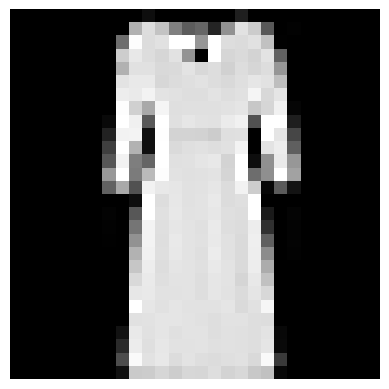

Target: Dress


In [14]:
idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[y_train[idx]])

## Data Augmentation and Pre-Processing

In [15]:
X_train_shaped, y_train_shaped = utils.preprocess_data(
    X_train, y_train,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = utils.preprocess_data(X_test, y_test)

*Preprocessing completed: 180000 samples

*Preprocessing completed: 10000 samples



# Train

In [16]:
histories = []
for i in range(0,iterations):
    print('Running iteration: %i' % i)

    # Saving the best checkpoint for each iteration
    filepath = "fashion_mnist_ResNet50-%i.hdf5" % i

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                          test_size=0.2, random_state=42)

    cnn = models.create_resnet50(input_shape = (img_height, img_width, channels), classes = num_classes)
    tick = time.perf_counter()
    history = cnn.fit(
        X_train_, y_train_,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10, start_from_epoch=50, verbose=1, mode='max'),  
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    tock = time.perf_counter()
    histories.append(history.history)
    print(f"Time to train model {i+1}: {(tock-tick)/60:.2f} minutes.")

Running iteration: 0


2023-11-07 20:49:15.640078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 20:49:15.672325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 20:49:15.672361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 20:49:15.676239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 20:49:15.676294: I tensorflow/compile

Epoch 1/100


2023-11-07 20:49:25.820612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-07 20:49:28.078172: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f347987b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 20:49:28.078213: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2023-11-07 20:49:28.087631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 20:49:28.190636: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4799/4800 [============================>.] - ETA: 0s - loss: 0.9167 - accuracy: 0.7000
Epoch 1: val_loss improved from inf to 0.51264, saving model to fashion_mnist_ResNet50-0.hdf5


/home/srijan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4800/4800 [==============================] - 202s 38ms/step - loss: 0.9166 - accuracy: 0.7000 - val_loss: 0.5126 - val_accuracy: 0.8129
Epoch 2/100
4799/4800 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.8225
Epoch 2: val_loss improved from 0.51264 to 0.45544, saving model to fashion_mnist_ResNet50-0.hdf5
4800/4800 [==============================] - 190s 40ms/step - loss: 0.4928 - accuracy: 0.8225 - val_loss: 0.4554 - val_accuracy: 0.8339
Epoch 3/100
4800/4800 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8454
Epoch 3: val_loss improved from 0.45544 to 0.42184, saving model to fashion_mnist_ResNet50-0.hdf5
4800/4800 [==============================] - 188s 39ms/step - loss: 0.4425 - accuracy: 0.8454 - val_loss: 0.4218 - val_accuracy: 0.8477
Epoch 4/100
4799/4800 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.8670
Epoch 4: val_loss improved from 0.42184 to 0.37537, saving model to fashion_mnist_ResNet50-0.hdf5
4

# Evaluation

## Training scores for loss and accuracy for all checkpoints

In [17]:
print('Training: \t%0.8f loss / %0.8f acc'   % (utils.get_avg(histories,'loss'), utils.get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (utils.get_avg(histories,'val_loss'), utils.get_avg(histories,'val_accuracy')))

Training: 	0.10551434 loss / 0.96154165 acc
Validation: 	0.18933475 loss / 0.93699998 acc


## Loss / accuracy of all models on testset

In [18]:
test_loss = []
test_accs = []

for i in range(0,iterations):
    cnn_ = tf.keras.models.load_model("fashion_mnist_ResNet50-%i.hdf5" % i)

    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])

    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))

print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss), np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Running final test with model 0: 0.2989 loss / 0.9167 acc

Average loss / accuracy on testset: 0.2989 loss / 0.91670 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


## Plotting accuracy and loss for each iteration

In [5]:
utils.plot_acc_loss('training', histories, 'accuracy', 'loss')
utils.plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

NameError: name 'histories' is not defined

## Evaluation for one model

In [19]:
RUN = 0 # you can choose one of the different models trained above
model = models.create_resnet50(input_shape = (img_height, img_width, channels), classes = num_classes)
model.load_weights("fashion_mnist_ResNet50-%i.hdf5" % RUN)

## Plotting accuracy and loss for one model

In [2]:
utils.plot_train_val('Model %i' % RUN, histories[RUN])

NameError: name 'utils' is not defined

## Displaying results of random predictions

In [4]:
utils.plot_sample_predictions(list(fashion_classes.values()), model, X_test_shaped, y_test)

NameError: name 'fashion_classes' is not defined

## Plotting confusion matrix

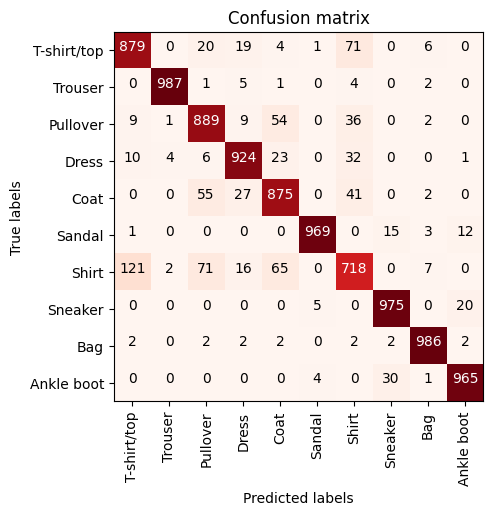

In [22]:
predictions = model.predict(X_test_shaped, verbose=0)
classes = np.argmax(predictions,axis=1)
utils.plot_confusion_matrix(confusion_matrix(y_test, classes), list(fashion_classes.values()))

## Report of f1, precision and recall

In [23]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.85      0.89      0.87      1000
           3       0.92      0.92      0.92      1000
           4       0.85      0.88      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.72      0.75      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

